# X followers: What do they tweet about?

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [136]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])

additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [137]:
X_train_en[-10:-1]

2242    MSFTCityNext Microsoft and partners will present safer city solutions at Smart City Expo SCEWC16...
2243                   bendy_ch Captain Sum Ting Wong and First Officer Ho Lee Fook https://t.co/AtAOccP0Bp
2244    oraclepartners Introducing Oracle PCMCS Find your profit winners in the cloud https://t.co/Q4XIz...
2245                                                           sfonplsql Oracle doing some data deep diving
2246    MSFTCityNext Microsoft and partners will present safer city solutions at Smart City Expo SCEWC16...
2247                                 sfonplsql is this the CSI team looking at connor_mc_d s knuckle damage
2248    JavaForumNord Cool stuff but HOW DO I GET MY COMPANY TO DO IT “ Java Champion MkHeck will tell u...
2249                                JavaForumNord bobbytank42 MkHeck the Meta Image https://t.co/2tUiLAUfk8
2250             sfonplsql When it comes to styling you can't beat Oracle employees https://t.co/FsXGb28k4e
Name: text_wo_#@, dtype: obj

In [115]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [7]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [8]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
175.4: oracle
109.1: cloud
102.5: new
72.8: data
72.0: 2016
66.6: iamcp
63.8: talend
63.4: check
62.7: thanks
54.7: database

['175.4: oracle', '109.1: cloud', '102.5: new', '72.8: data', '72.0: 2016', '66.6: iamcp', '63.8: talend', '63.4: check', '62.7: thanks', '54.7: database']


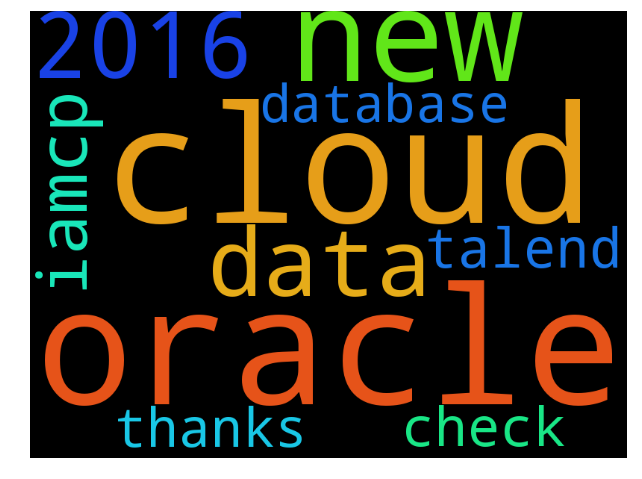

In [9]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
93.4: cloud
60.8: oracle
44.2: lukaseder
44.0: not
43.0: it's
41.9: but
40.7: talend
40.6: new
39.0: data
35.0: bigdata
34.1: check
34.0: iamcp
31.6: day
31.5: week
29.5: see
27.4: use
27.3: work
26.7: still
26.5: service
26.5: 5

Topic #1:
114.6: oracle
71.1: 2016
61.9: new
59.8: thanks
44.9: database
39.9: ukoug
35.9: patch
35.3: available
33.8: data
33.5: october
32.6: iamcp
29.3: check
25.9: what's
25.6: join
25.4: microsoft
25.2: 2
24.5: business
23.1: look
23.1: talend
22.6: 10

['93.4: cloud', '60.8: oracle', '44.2: lukaseder', '44.0: not', "43.0: it's", '41.9: but', '40.7: talend', '40.6: new', '39.0: data', '35.0: bigdata', '34.1: check', '34.0: iamcp', '31.6: day', '31.5: week', '29.5: see', '27.4: use', '27.3: work', '26.7: still', '26.5: service', '26.5: 5']
['114.6: oracle', '71.1: 2016', '61.9: new', '59.8: thanks', '44.9: database', '39.9: ukoug', '35.9: patch', '35.3: available', '33.8: data', '33.5: october', '32.6: iamcp', '29.3: check', "25.9: what's", '25.

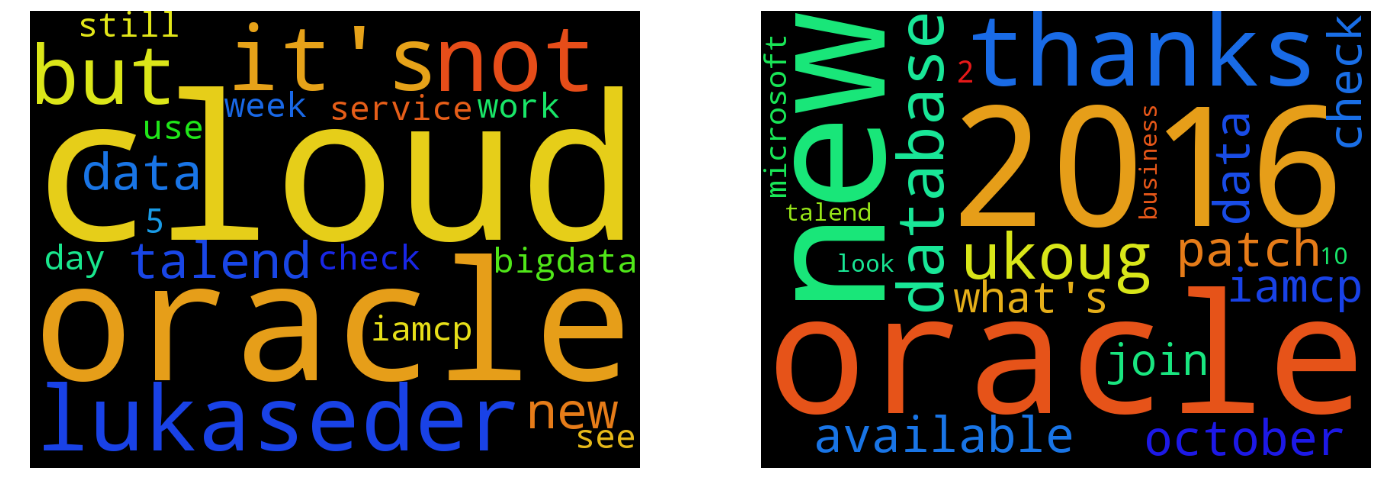

In [10]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
50.8: not
49.9: cloud
41.8: but
38.3: talend
36.6: day
34.7: data
33.9: oracle
31.5: bigdata
30.5: see
30.0: it's
26.2: lukaseder
25.6: iamcp
23.2: 5
21.9: use
18.9: week
18.3: right
17.0: check
16.6: machinelearning
16.6: spark
16.6: open

Topic #1:
41.5: oracle
38.8: ukoug
37.7: data
32.9: 2016
29.9: like
29.0: 2
25.1: talend
24.7: lukaseder
23.7: community
23.0: look
21.2: patch
20.9: https
20.7: thanks
19.9: hadoop
19.7: no
19.1: bigdata
19.1: rmoff
19.0: big
18.8: available
18.4: really

Topic #2:
101.2: new
100.0: oracle
49.8: cloud
41.4: database
38.5: sfonplsql
36.2: 2016
30.5: thanks
30.5: check
29.8: sql
28.2: great
28.2: what's
27.0: orclapex
26.2: help
24.7: plsql
24.4: find
23.8: iamcp
23.4: join
22.8: work
22.7: programming
22.2: javaooq

['50.8: not', '49.9: cloud', '41.8: but', '38.3: talend', '36.6: day', '34.7: data', '33.9: oracle', '31.5: bigdata', '30.5: see', "30.0: it's", '26.2: lukaseder', '25.6: iamcp', '23.2: 5', '21.9: use', '18.9: week', '18.3: rig

(0.0, 1.0, 0.0, 1.0)

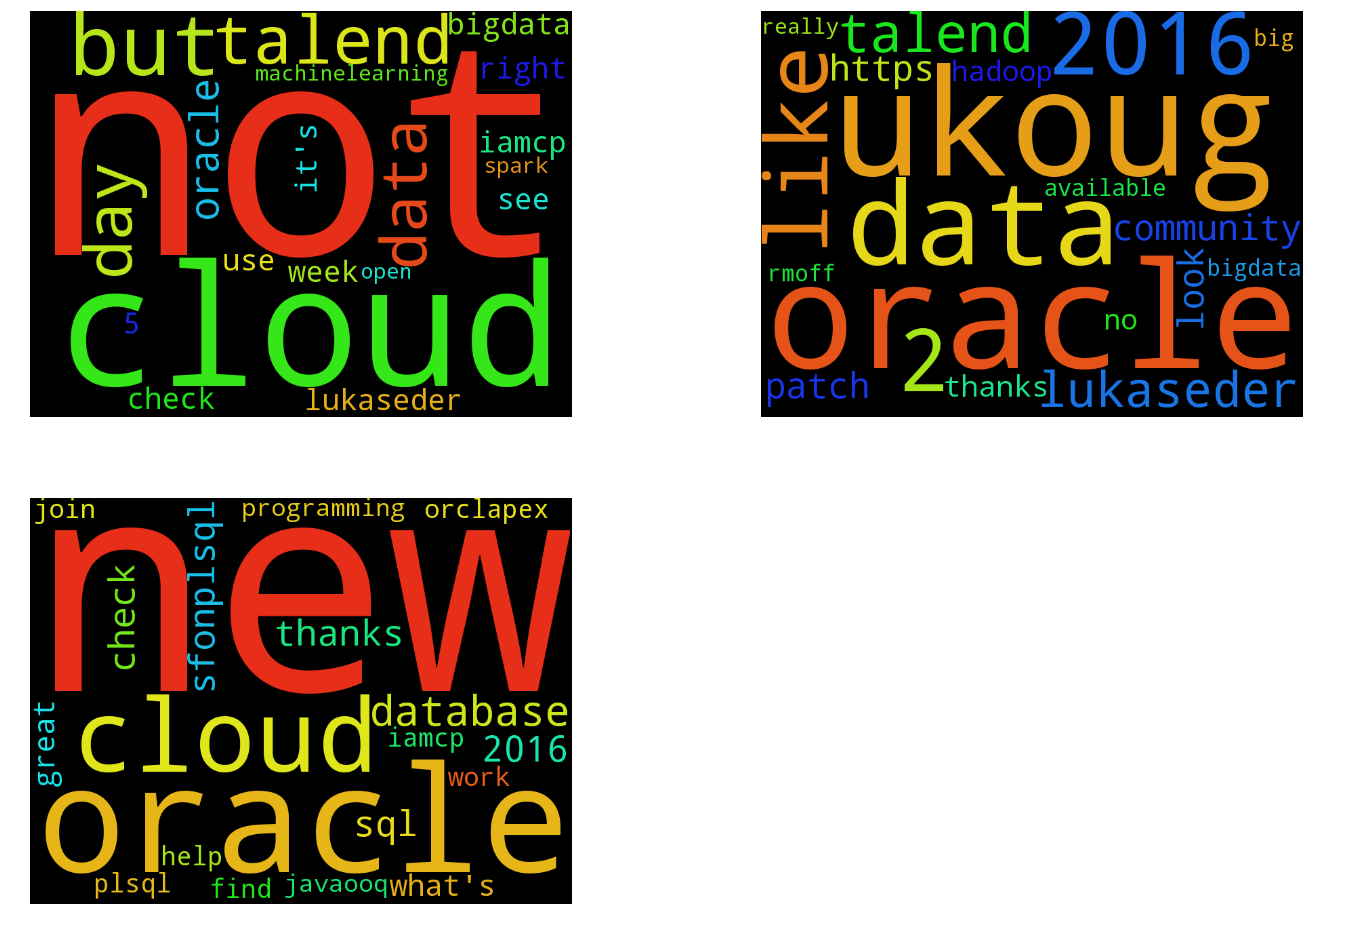

In [11]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
48.4: not
41.3: talend
30.7: check
30.2: iamcp
29.9: see
29.0: events
27.3: day
24.0: use
23.3: oracle
21.8: but
20.8: it's
19.4: week
16.6: excited
16.4: lots
16.3: latest
16.3: part
16.1: 5
14.7: bigdata
14.7: open
14.0: happening

Topic #1:
66.5: oracle
54.8: 2016
39.9: ukoug
37.8: data
35.7: patch
35.3: available
33.3: thanks
32.9: database
31.9: october
29.2: 2
24.4: no
23.7: check
23.0: look
20.5: what's
20.4: 10
19.9: really
19.6: good
19.0: rmoff
18.5: take
17.1: sessions

Topic #2:
79.0: new
72.5: cloud
58.9: oracle
30.7: sfonplsql
29.4: microsoft
28.9: thanks
27.8: iamcp
24.8: iot
24.4: orclapex
23.1: code
21.3: database
20.3: 12.2
20.2: way
19.0: post
18.8: know
18.5: work
18.4: want
18.1: w
17.8: also
17.8: world

Topic #3:
38.2: lukaseder
34.4: data
26.7: oracle
25.2: cloud
22.9: new
22.7: help
22.6: programming
22.6: hadoop
21.5: talend
21.0: javaooq
20.2: but
19.5: week
19.1: business
18.9: find
18.9: big
18.1: learn
18.0: stay
17.1: team
16.8: jooq
16.7: expla

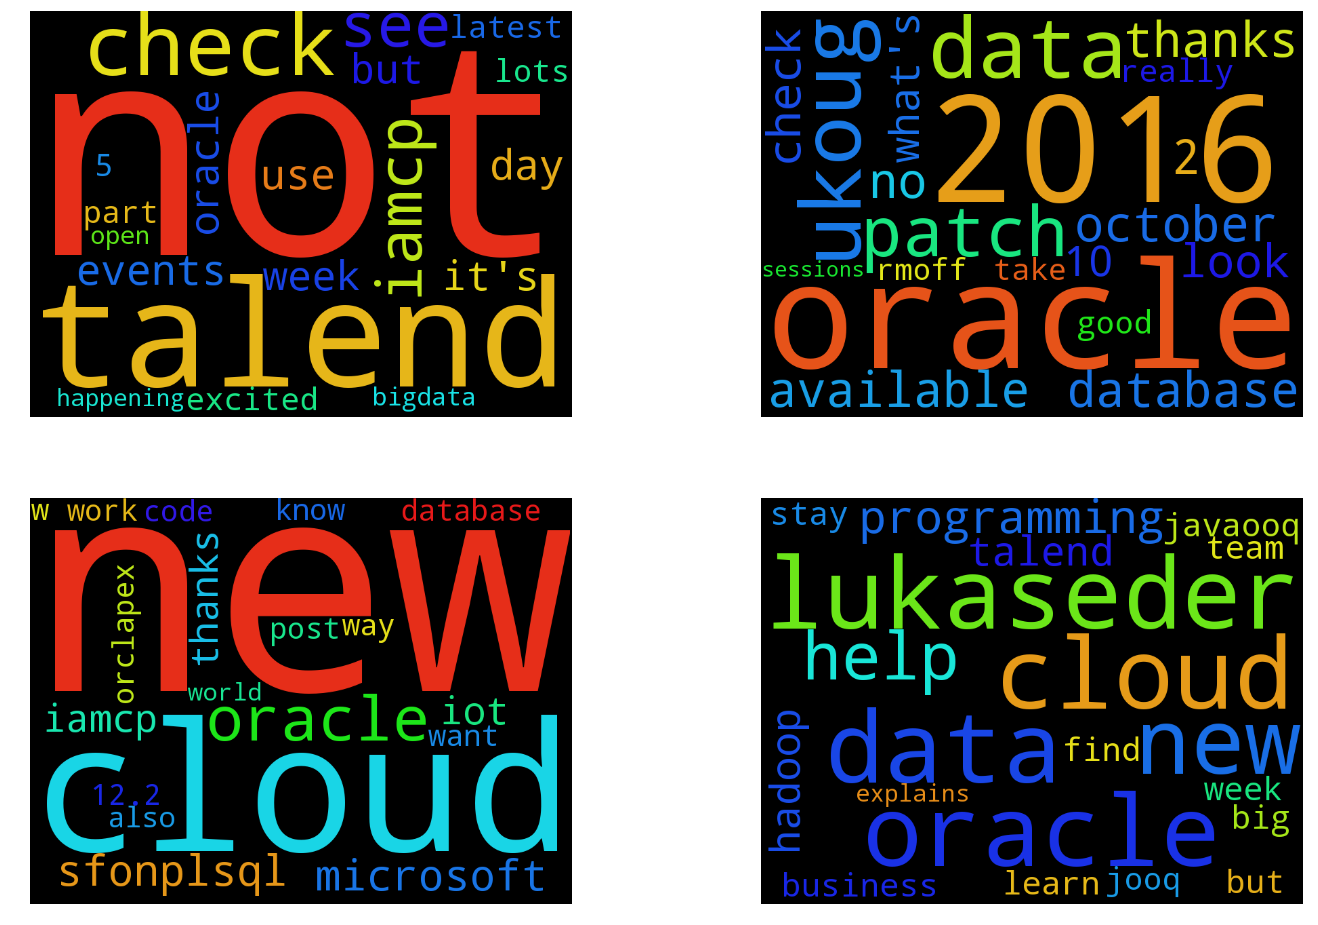

In [12]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [138]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(6830, 6830)

In [139]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,6820,6821,6822,6823,6824,6825,6826,6827,6828,6829
word,,,,,,,,,,,,,,,,,,,,,
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
)=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
..,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
co_occurrences.columns = vocab
co_occurrences.head()

,$,%,):,)=,..,0,0.2,0.4,0.5,00,...,😊,😎,😜,😢,😤,😳,🙄,🤓,🤘,🦁
word,,,,,,,,,,,,,,,,,,,,,
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
)=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
..,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
vendors = ['oracle', 'microsoft']
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    
coocs = co_occurrences.loc['oracle']
coocs.head(20)
sorted = coocs.sort_values(ascending = False)
sorted    

cloud                      84
database                   59
2016                       47
new                        42
available                  40
october                    37
service                    36
patch                      30
data                       27
psu                        26
bp                         26
what's                     25
inside                     24
mikedietrichde             22
12.2                       21
check                      20
help                       19
week                       19
profit                     18
https://t.co/zblwbcrvoy    18
business                   18
weblogic                   18
forms                      17
12c                        17
oraclepartners             17
find                       15
day                        15
oct                        14
visualization              13
winner                     12
                           ..
mind                        0
mindthebridge               0
mine      

# Tweets in German

In [15]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train_de = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])

additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [16]:
X_train_de[-10:]

1095                                    JavaBasel Schön war's Bis zum nächsten Jahr https://t.co/DMWGfL8qKG
1096                                    JavaBasel Schön war's Bis zum nächsten Jahr https://t.co/DMWGfL8qKG
1097    StressBookAG Danke startup_valley startup interview gefährdungsbeurteilung stress eumanagestress...
1098             bendy_ch der meine eine bestätigt deine frage mit einem JA ;-) Donutrunde jcfrick jonock01
1099    SwissITReseller Schweizer Telcos senken Terminierungsgebühren Die drei Schweizer Mobilfunknetzbe...
1100                                              bendy_ch nohillside das wäre eine schöne Kulisse dafür ..
1101                 Online Marketing permanente Wissens-Aktualisierung ist gefragt https://t.co/7eA2k468rz
1102    jugka Die Aufzeichnung unseres JVM Talks von TobiasFrech ist online am Anfang etwas dunkel Viel ...
1103    FrankGeisler1 SAP Forum Kickoff in Regensdorf neue innovative Ansätze machen Lust auf eine spann...
1104         JuhuDesign comp

In [18]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)
feature_names = vectorizer.get_feature_names()

In [19]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - German

Topic #0:
95.6: javaforumnord
81.4: jfn16
66.3: nicht
56.3: msenterprisede
54.3: java
49.6: deutsche
47.0: https://t…
46.0: danke
45.3: sicherheit
44.9: sap



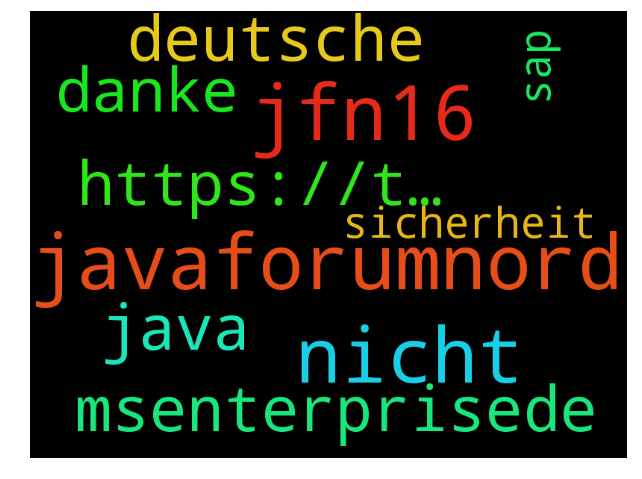

In [20]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

Topic #0:
32.6: oracle
29.5: nicht
29.5: cloud
28.1: neue
27.4: doag2016
24.0: orclapex
21.5: dpk16
21.4: mehr
20.2: appsassociatesd
18.5: sucht
17.9: swiss
17.7: ab
17.5: aarnoaukia
17.1: kommt
16.6: uhr
16.6: sachen
16.5: ausprobieren
16.4: sehr
16.3: kennt
16.0: oraclecloudday

Topic #1:
80.8: jfn16
80.8: javaforumnord
55.7: msenterprisede
53.7: java
49.0: deutsche
46.5: https://t…
44.7: sicherheit
44.3: sap
44.1: danke
43.6: msft
42.5: setzt
41.3: heute
40.7: sicherheitszertifikat
40.7: mscloudde
40.7: d-trust
40.7: germany
40.7: made
39.7: forum
36.8: nicht
35.2: “



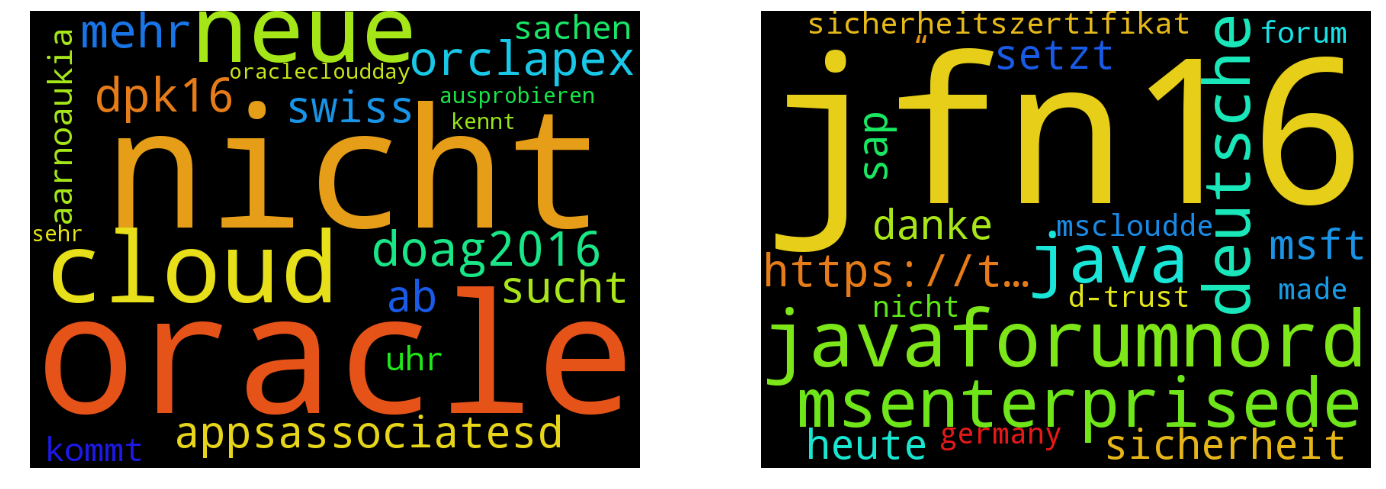

In [21]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

Topic #0:
27.4: doag2016
23.1: 4
21.7: neues
21.3: dpk16
20.1: appsassociatesd
17.4: swiss
16.7: oracle
16.3: sehr
15.9: ganz
15.8: orclapex
15.3: :-)
15.1: unternehmen
15.0: a
14.6: nicht
13.9: jahr
13.8: schweizer
13.8: wachstum
13.6: talks
13.4: 28
13.3: event

Topic #1:
64.8: javaforumnord
44.2: danke
43.2: sap
41.5: heute
39.5: jfn16
35.8: “
28.9: „
26.0: geht
21.9: s
18.9: erpsourcing
18.8: kommt
18.1: nicht
17.7: los
17.5: aber
17.2: frankgeisler1
16.6: nur
16.4: digitale
16.2: gut
15.8: 2016
15.8: hannover

Topic #2:
55.6: msenterprisede
49.1: java
48.7: deutsche
46.2: https://t…
44.6: sicherheit
43.4: msft
42.3: setzt
41.5: jfn16
40.6: made
40.6: germany
40.6: mscloudde
40.6: sicherheitszertifikat
40.6: d-trust
35.1: mehr
33.6: nicht
29.9: forum
28.2: cloud
27.7: neue
23.7: nord
19.5: javaforumnord



(0.0, 1.0, 0.0, 1.0)

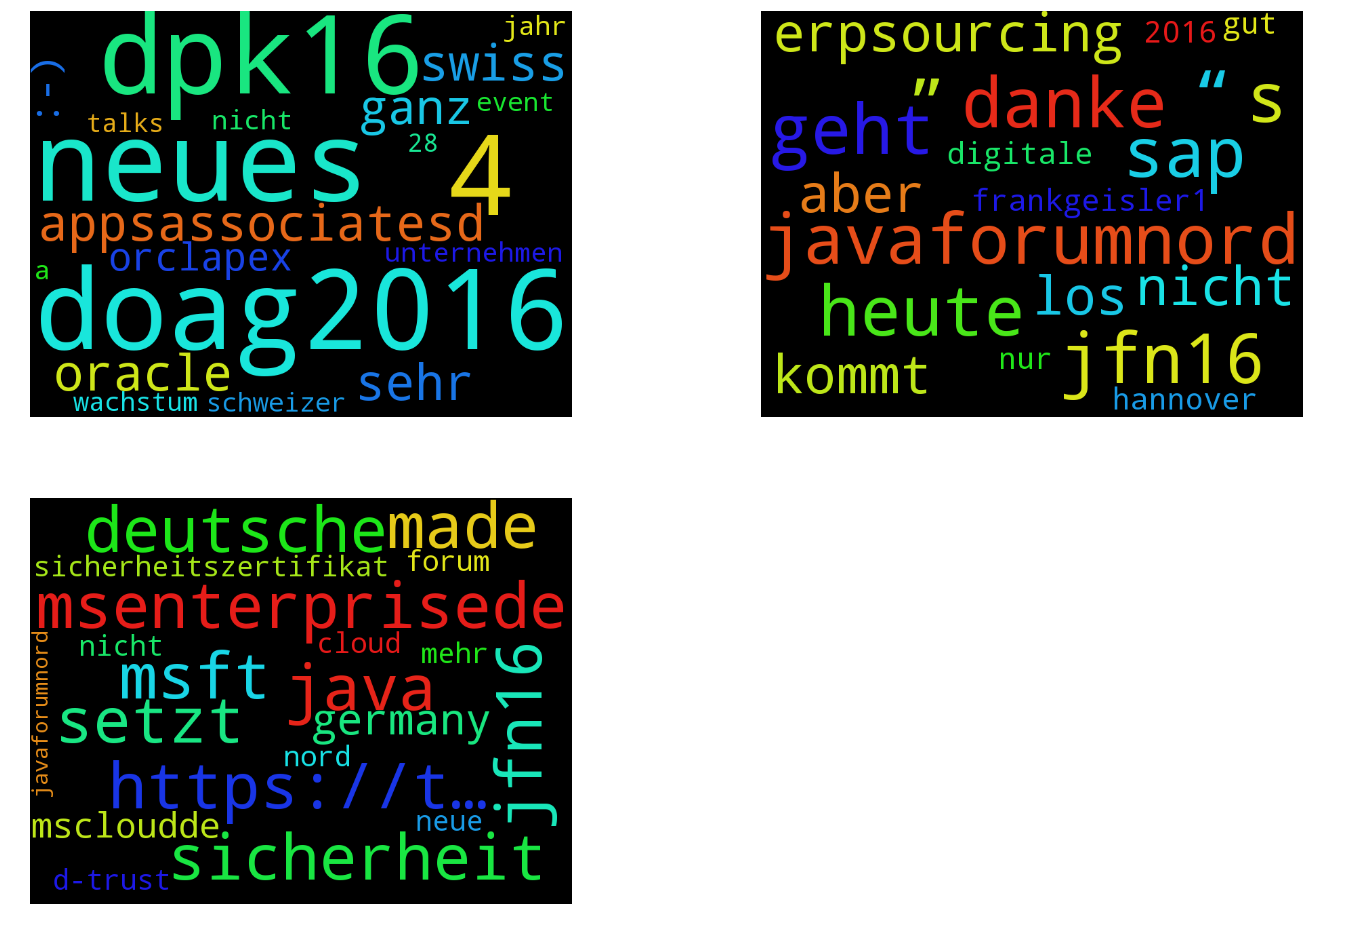

In [22]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - German

Topic #0:
24.4: doag2016
24.2: 4
23.8: javaforumnord
23.7: orclapex
21.7: neues
20.0: appsassociatesd
17.7: wer
17.3: dpk16
15.0: ab
14.7: online
14.5: meetup
14.5: kommt
14.0: uhr
13.8: nächste
13.8: jahr
13.8: social
13.4: 28
13.4: startet
13.0: event
12.6: talks

Topic #1:
52.8: javaforumnord
45.0: danke
37.9: jfn16
36.3: heute
35.7: “
29.2: sap
28.8: „
24.5: 2016
21.9: s
18.8: erpsourcing
16.5: digitale
16.5: vortrag
15.7: hannover
14.4: geht
14.2: nutzen
14.1: 4.0
14.0: industrie
13.9: kollegen
12.4: ;)
12.3: statt

Topic #2:
53.5: java
50.2: msenterprisede
49.3: nicht
46.3: deutsche
46.0: https://t…
44.5: sicherheit
43.3: msft
42.9: jfn16
42.3: setzt
40.5: made
40.5: germany
40.5: mscloudde
40.5: sicherheitszertifikat
40.5: d-trust
37.8: mehr
34.7: forum
29.3: cloud
29.3: neue
27.0: nord
22.5: oracle

Topic #3:
16.7: schweizer
16.1: digitalisierung
15.8: finden
15.5: unternehmen
15.3: tag
13.4: sehr
13.1: gibt
12.2: :-)
11.9: roadshow
11.9: the
11.7: aber
11.6: nicht
10.0: aurapl

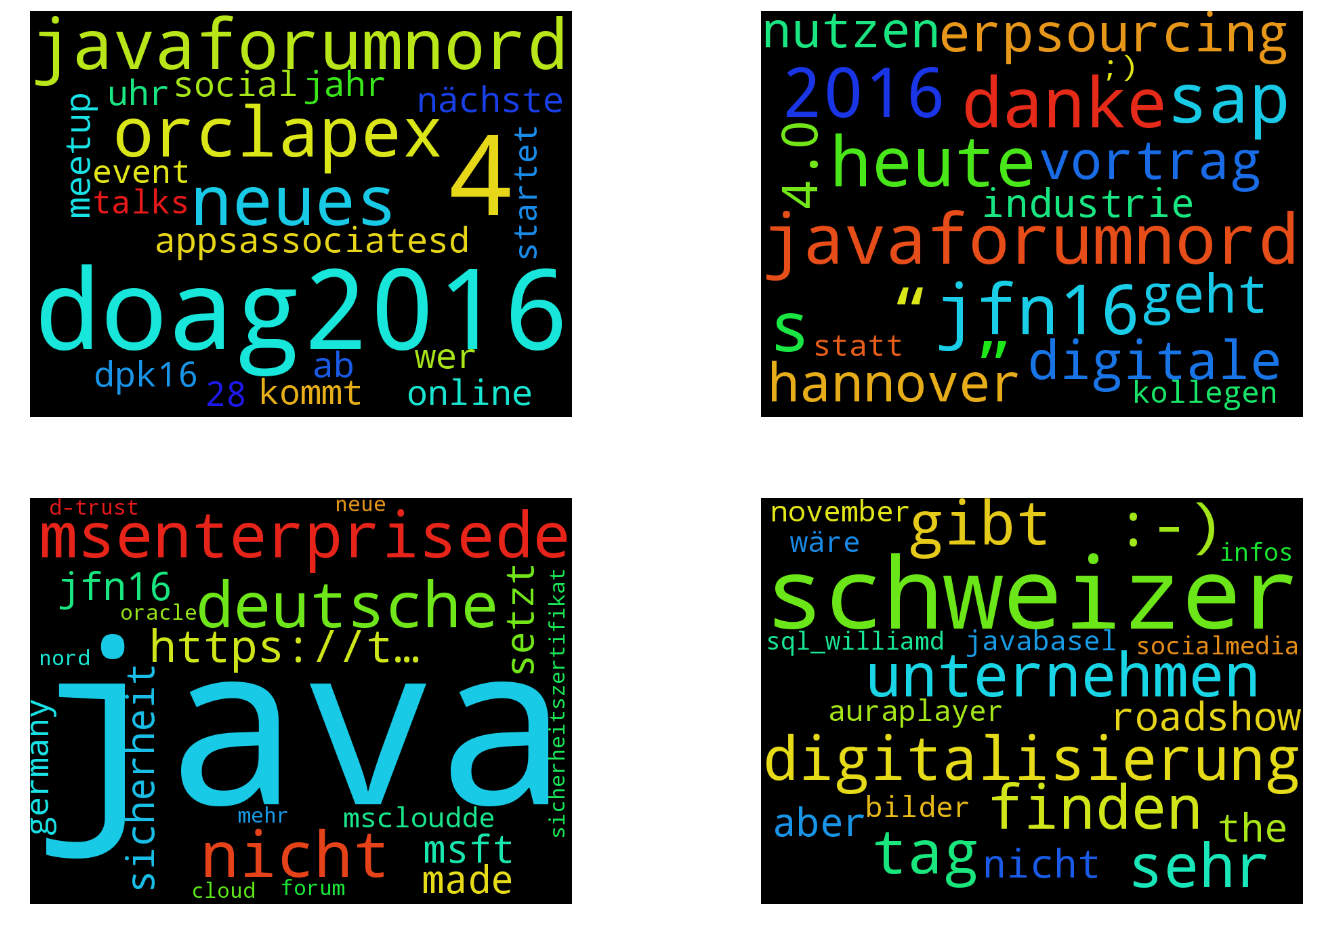

In [23]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

# Tweets in French

In [31]:
tweets_french = pd.read_csv(french_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_french['text_wo_#'] = tweets_french['text_processed'].apply(lambda x: remove_hash(x))
tweets_french['text_wo_#@'] = tweets_french['text_wo_#'].apply(lambda x: remove_at(x))

X_train_fr = tweets_french['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [32]:
X_train_fr[-10:]

43    strauch5 Formation Introduction à Oracle SQL du 19 au 21 Décembre Exécution garantie https://t.c...
44    TalendFR Découvrez les innovations phares et les bonnes pratiques du BigData Inscrivez-vous au T...
45    Nous développons notre implantation en Suisse romande et recherchons un e Employé e de support d...
46                                    Cycle de vie client et CRM | Univers retail https://t.co/r7KS9iScjc
47                 Palexpo recherche un e Chargé e des relations publiques presse https://t.co/s0MMPGr7A8
48                                                                      amadedotch AlpineLabs coole sache
49    JPMichenaud Modernisez votre entreprise grâce aux solutions Oracle ERP Cloud Rdv le 8 nov Oracle...
50                                         Erni recrute à Lausanne Rejoignez-nous https://t.co/fJ2om1AVLa
51    La FinTech et la Sécurité Informatique parmi les 10 objectifs de la stratégie économique 2030 de...
52    TalendFR Découvrez les innovations phare

In [33]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)
feature_names = vectorizer.get_feature_names()

In [34]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - French

Topic #0:
11.4: oracle_france
9.8: welovestartups
9.0: oracle
8.3: oracledigital
8.2: rdv
7.4: day
7.4: jpmichenaud
5.8: 8
5.8: nov
5.0: talendfr



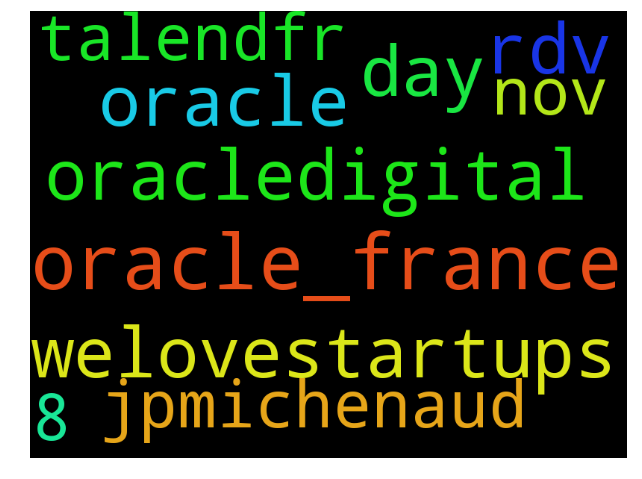

In [35]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

Topic #0:
7.8: oracledigital
7.8: rdv
5.4: 8
5.4: nov
4.5: oracle
3.7: e
3.0: suisse
3.0: cloud
3.0: https://t.co/4jbuphyxsi
3.0: recommendations
2.9: entreprises
2.9: blog
2.6: oracle_france
2.4: day
2.3: talendfr
2.2: swissdataforum
2.2: inscrivez-vous
2.2: commande
2.2: grâce
2.2: rh

Topic #1:
9.1: oracle_france
8.7: welovestartups
5.5: jpmichenaud
5.1: day
4.7: oracle
3.8: https://t.co/yyohfsispq
3.8: start-ups
3.8: table-ronde
3.8: frdigitale
3.8: damiengromier
3.8: ceo
3.8: anime
3.0: bigdata
3.0: talend
3.0: reward
3.0: gérard
3.0: strauch5
3.0: offer
3.0: sol
2.9: we



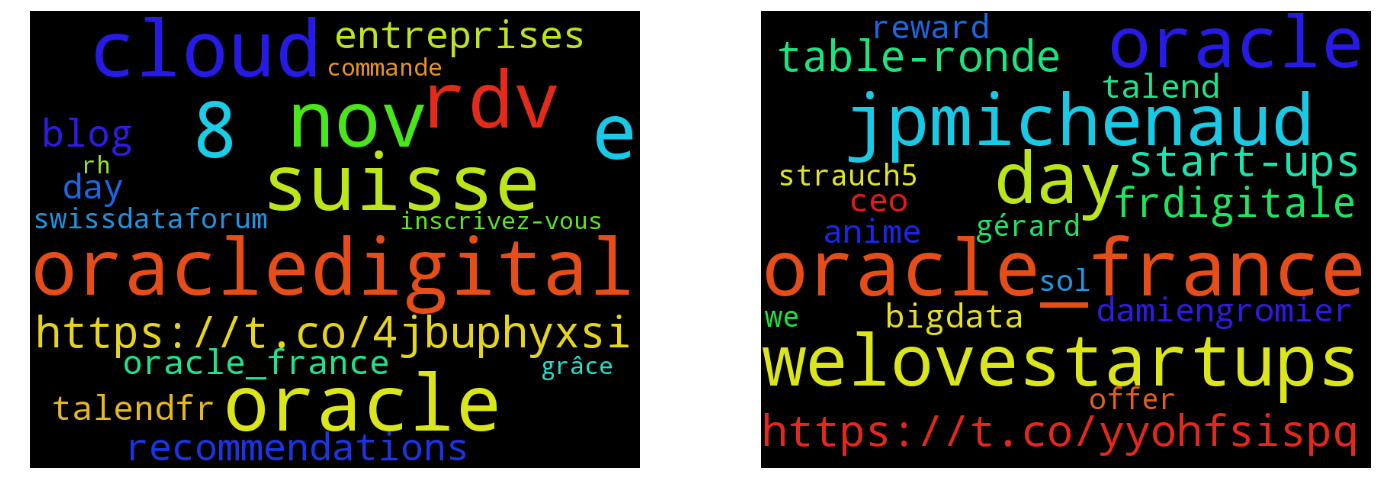

In [36]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

Topic #0:
6.9: oracledigital
6.9: rdv
5.2: 8
5.2: nov
4.4: oracle
2.9: cloud
2.9: https://t.co/4jbuphyxsi
2.8: recommendations
2.8: blog
2.1: inscrivez-vous
2.1: grâce
2.1: swissdataforum
2.1: talendfr
2.1: talendconnect
2.1: rh
2.1: genève
2.1: modernisez
2.1: découvrez
2.1: oraclefinfr
2.1: hr

Topic #1:
3.7: https://t.co/yyohfsispq
3.7: start-ups
3.7: frdigitale
3.7: table-ronde
3.7: welovestartups
3.7: damiengromier
3.6: anime
3.6: oracle_france
2.9: talend
2.9: jpmichenaud
2.9: bigdata
2.8: talendfr
2.1: intégration
2.1: 2016
2.1: là
2.1: opensource
2.1: a
2.1: comment
2.1: https://t.co/dbxy4iat48
2.1: voit

Topic #2:
7.6: oracle_france
6.8: day
6.0: welovestartups
4.4: oracle
3.7: e
2.9: jpmichenaud
2.9: competitive
2.9: sol
2.9: we
2.9: offer
2.9: by
2.9: gérard
2.9: ceo
2.9: appyreward
2.9: reward
2.8: strauch5
2.8: at
2.8: digital
2.8: fournier
2.1: entreprises



(0.0, 1.0, 0.0, 1.0)

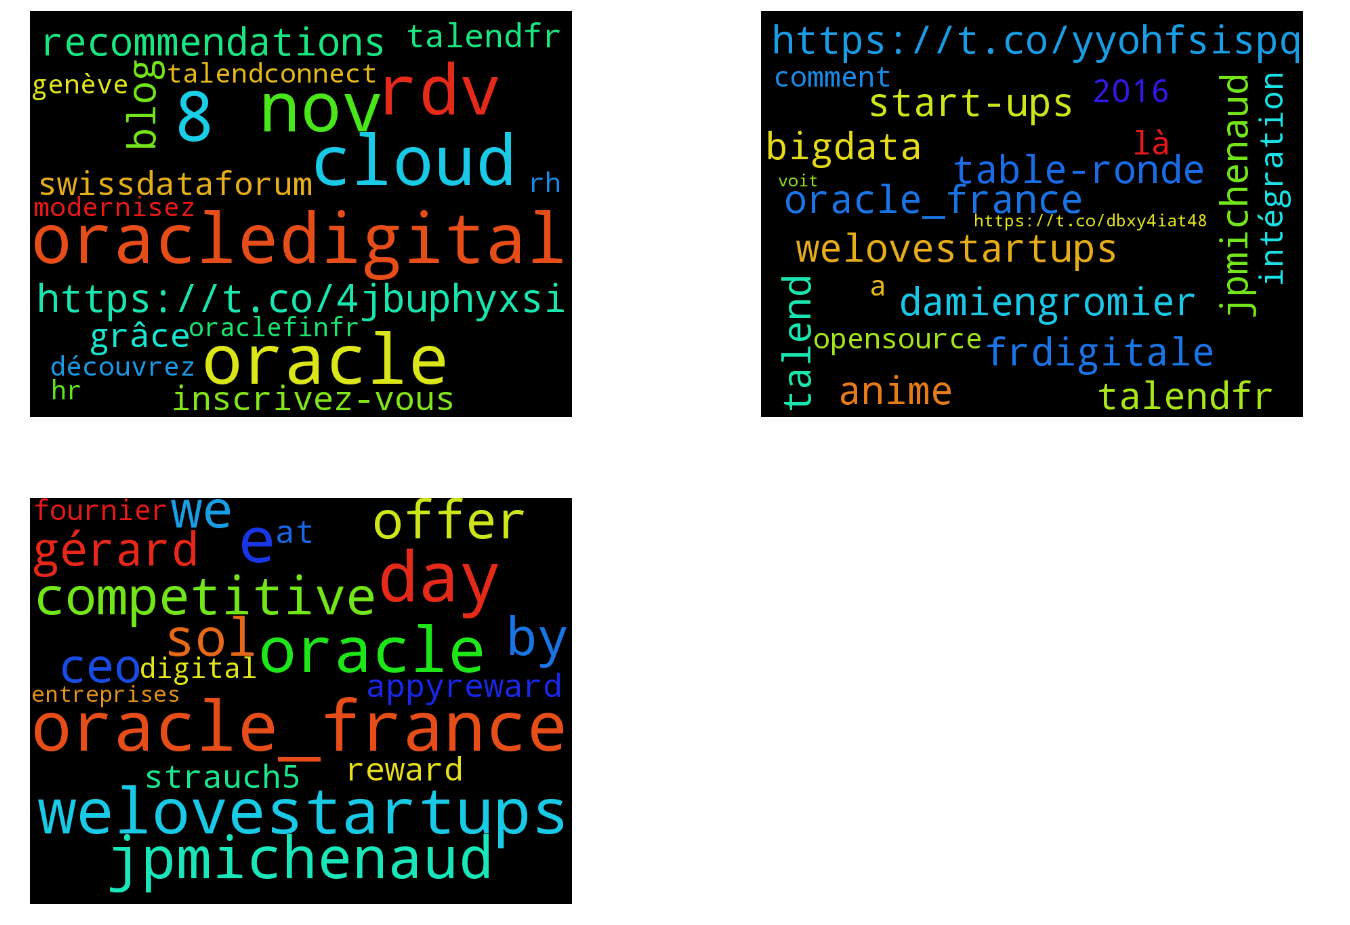

In [37]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - French

Topic #0:
2.8: recommendations
2.8: blog
2.7: oracle
2.0: inscrivez-vous
2.0: talendfr
2.0: talendconnect
2.0: genève
2.0: découvrez
2.0: https://t.co/dbxy4iat48
2.0: là
2.0: voit
2.0: 2016
2.0: bigdata
2.0: innovations
2.0: :-)
2.0: pratiques
2.0: bonnes
2.0: oracle_france
2.0: phares
1.3: tilkeeapp

Topic #1:
3.7: welovestartups
3.6: https://t.co/yyohfsispq
3.6: start-ups
3.6: oracle_france
3.6: frdigitale
3.6: table-ronde
3.6: damiengromier
3.6: anime
2.8: jpmichenaud
2.8: talend
2.8: bigdata
2.7: talendfr
2.0: intégration
2.0: opensource
2.0: a
2.0: comment
2.0: https://t.co/fjgmagx9ia
1.9: données
1.9: conquis
1.9: marché

Topic #2:
5.9: oracle_france
5.1: welovestartups
5.1: day
3.6: e
3.6: oracle
2.8: jpmichenaud
2.8: by
2.8: strauch5
2.8: competitive
2.8: sol
2.8: we
2.8: offer
2.8: gérard
2.8: ceo
2.8: reward
2.8: appyreward
2.7: at
2.7: digital
2.7: fournier
2.0: 21

Topic #3:
7.5: oracledigital
6.7: rdv
5.1: 8
5.1: nov
2.8: cloud
2.8: https://t.co/4jbuphyxsi
2.8: oracle
2.0:

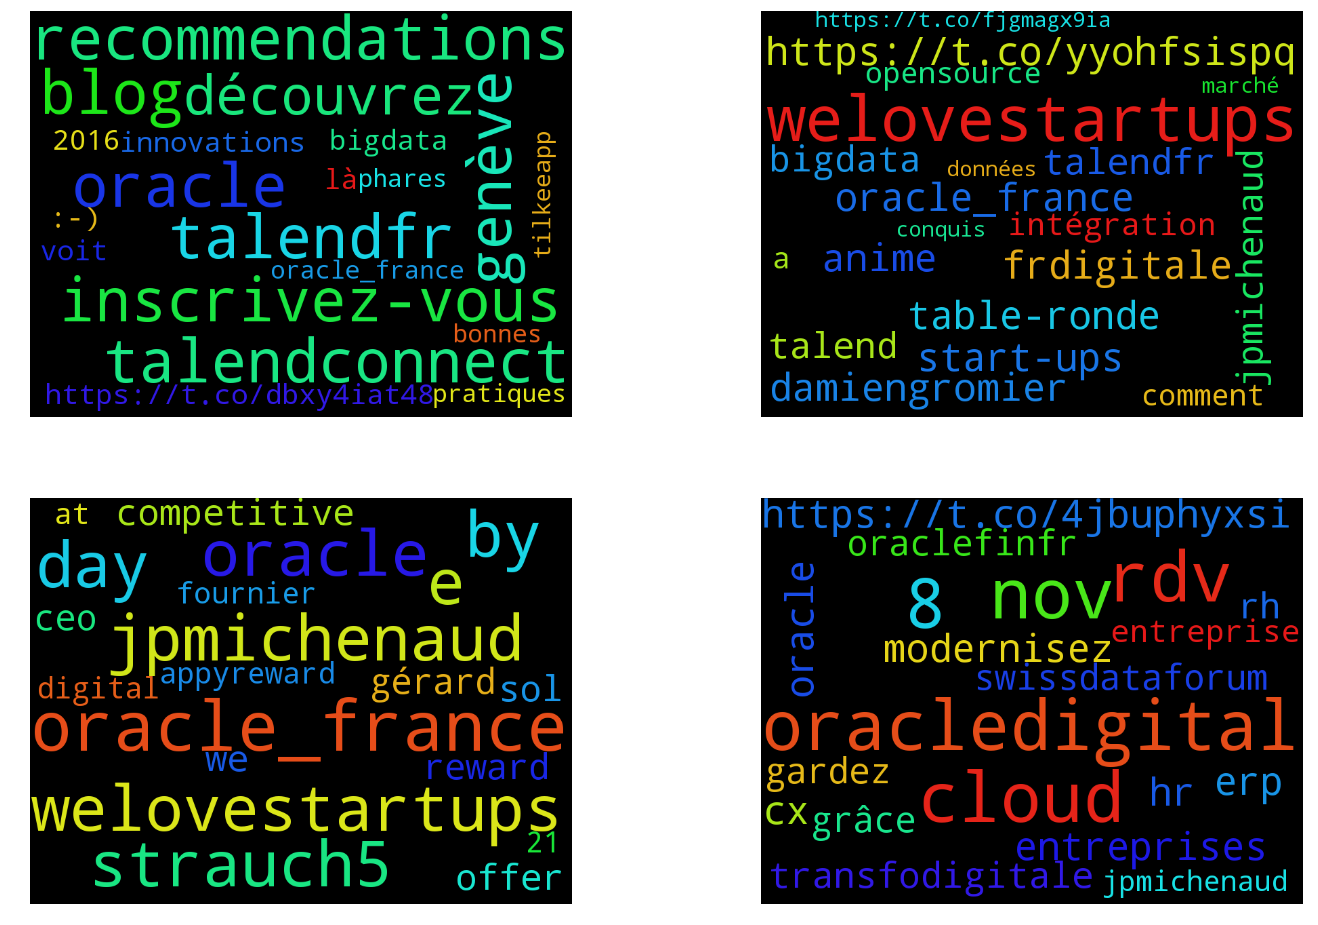

In [38]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)